In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [11]:
# Imports
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from tensorflow.keras.utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

In [58]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparams
SAMPLE_COUNT = 85000
TRAINING_RATIO = 0.9
IMAGE_SIZE = 64
EPOCHS = 10
BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

# Test Set Augmentation (Only Rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load Datasets
training_set = train_datagen.flow_from_directory(
    'Malaria Cells/training_set',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_set = test_datagen.flow_from_directory(
    'Malaria Cells/testing_set',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Class Weights for Imbalance
class_weights = {0: 1.0, 1: 1.5}  # Adjust based on class distribution


Found 27558 images belonging to 2 classes.
Found 15832 images belonging to 2 classes.


In [8]:
# Check a batch of data from the training set
batch = next(iter(training_set))
print(f"Input Shape: {batch[0].shape}")
print(f"Label Shape: {batch[1].shape}")
print(f"First Batch Labels: {batch[1]}")


Input Shape: (32, 64, 64, 3)
Label Shape: (32,)
First Batch Labels: [1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1.]


## Traditional ML 


#### Feature Extraction using VGG19

In [5]:
from keras.applications import VGG19
from keras.models import Model

# Load VGG19 model without the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Create a new model that outputs the features from the last convolutional layer
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from training data
features_train = model.predict(training_set)

c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


862/862 ━━━━━━━━━━━━━━━━━━━━ 557s 645ms/step


In [6]:
# Get labels from the generator
labels_train = training_set.classes  # This will give you the true labels


In [7]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense

# Flatten the features if necessary (depends on your classifier)
features_train_flattened = features_train.reshape(features_train.shape[0], -1)

# SVM Classifier
svm_model = SVC()
svm_model.fit(features_train_flattened, labels_train)
svm_predictions = svm_model.predict(features_train_flattened)
print(f"SVM Accuracy: {accuracy_score(labels_train, svm_predictions) * 100:.2f}%")

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features_train_flattened, labels_train)
rf_predictions = rf_model.predict(features_train_flattened)
print(f"Random Forest Accuracy: {accuracy_score(labels_train, rf_predictions) * 100:.2f}%")

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(features_train_flattened, labels_train)
gb_predictions = gb_model.predict(features_train_flattened)
print(f"Gradient Boosting Accuracy: {accuracy_score(labels_train, gb_predictions) * 100:.2f}%")

# Neural Network Classifier
nn_model = Sequential()
nn_model.add(Dense(512, activation='relu', input_shape=(features_train_flattened.shape[1],)))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the extracted features
nn_model.fit(features_train_flattened, labels_train, epochs=10, batch_size=32)

# Predict on training set
nn_predictions = (nn_model.predict(features_train_flattened) > 0.5).astype("int32")
print(f"Neural Network Accuracy: {accuracy_score(labels_train, nn_predictions) * 100:.2f}%")


SVM Accuracy: 55.24%
Random Forest Accuracy: 100.00%
Gradient Boosting Accuracy: 64.11%


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.5042 - loss: 0.7131
Epoch 2/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5014 - loss: 0.6934
Epoch 3/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4979 - loss: 0.6934
Epoch 4/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5043 - loss: 0.6933
Epoch 5/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4938 - loss: 0.6933
Epoch 6/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4961 - loss: 0.6932
Epoch 7/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5053 - loss: 0.6931
Epoch 8/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4977 - loss: 0.6932
Epoch 9/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4982 - loss: 0.6932
Epoch 10/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4904 - loss: 0.6932
862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Neural Network Accuracy: 50.01%


In [8]:
# Extract features from validation data
features_val = model.predict(test_set)

# Get labels from the generator
labels_val = test_set.classes  # This will give you the true labels


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


495/495 ━━━━━━━━━━━━━━━━━━━━ 313s 631ms/step


In [9]:
# Flatten the features if necessary (depends on your classifier)
features_val_flattened = features_val.reshape(features_val.shape[0], -1)

# SVM Predictions
svm_predictions_val = svm_model.predict(features_val_flattened)
print(f"SVM Validation Accuracy: {accuracy_score(labels_val, svm_predictions_val) * 100:.2f}%")

# Random Forest Predictions
rf_predictions_val = rf_model.predict(features_val_flattened)
print(f"Random Forest Validation Accuracy: {accuracy_score(labels_val, rf_predictions_val) * 100:.2f}%")

# Gradient Boosting Predictions
gb_predictions_val = gb_model.predict(features_val_flattened)
print(f"Gradient Boosting Validation Accuracy: {accuracy_score(labels_val, gb_predictions_val) * 100:.2f}%")

# Neural Network Predictions
nn_predictions_val = (nn_model.predict(features_val_flattened) > 0.5).astype("int32")
print(f"Neural Network Validation Accuracy: {accuracy_score(labels_val, nn_predictions_val) * 100:.2f}%")


SVM Validation Accuracy: 50.51%
Random Forest Validation Accuracy: 49.81%
Gradient Boosting Validation Accuracy: 50.44%
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Neural Network Validation Accuracy: 50.25%


## CNN Models (Simpler to Advanced)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Initialize the CNN
CNN_1 = Sequential()

# Layer 1: Convolution + MaxPooling + BatchNormalization
CNN_1.add(Conv2D(64, (3, 3), input_shape=(64, 64, 3), activation='relu'))
CNN_1.add(MaxPooling2D(pool_size=(2, 2)))
CNN_1.add(BatchNormalization())

# Layer 2: Convolution + MaxPooling + BatchNormalization
CNN_1.add(Conv2D(128, (3, 3), activation='relu'))
CNN_1.add(MaxPooling2D(pool_size=(2, 2)))
CNN_1.add(BatchNormalization())

# Layer 3: Convolution + MaxPooling + BatchNormalization
CNN_1.add(Conv2D(256, (3, 3), activation='relu'))
CNN_1.add(MaxPooling2D(pool_size=(2, 2)))
CNN_1.add(BatchNormalization())

# Flatten
CNN_1.add(Flatten())
# Fully Connected Layers + Dropout
CNN_1.add(Dense(units=256, activation='relu'))
CNN_1.add(Dropout(0.5))  # Dropout to reduce overfitting
CNN_1.add(Dense(units=128, activation='relu'))
CNN_1.add(Dropout(0.5))

# Use a single output neuron with sigmoid activation
CNN_1.add(Dense(units=1, activation='sigmoid'))


# Compile the CNN
CNN_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
CNN_1.save("CNN.keras")  # Saves the model as an HDF5 file
# classifier.save_weights("CNN.weights.keras")


transfer_model.save("VGG16.keras")  # Saves the model as an HDF5 file
# transfer_model.save_weights("VGG16.weights.keras")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import LambdaCallback

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


def debug_batch(batch, logs):
    print(f"Batch Shape: {batch}")

debug_callback = LambdaCallback(on_batch_end=debug_batch)

# Add to the fit call
history = CNN_1.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=20,
    validation_data=test_set,
    validation_steps=len(test_set),
    callbacks=[early_stop, reduce_lr, debug_callback],
)



Epoch 1/20
Batch Shape: 0
  1/862 ━━━━━━━━━━━━━━━━━━━━ 38:23 3s/step - accuracy: 0.4375 - loss: 1.2718Batch Shape: 1
  2/862 ━━━━━━━━━━━━━━━━━━━━ 6:57 485ms/step - accuracy: 0.4844 - loss: 1.2625Batch Shape: 2
  3/862 ━━━━━━━━━━━━━━━━━━━━ 6:54 483ms/step - accuracy: 0.5104 - loss: 1.2557Batch Shape: 3
  4/862 ━━━━━━━━━━━━━━━━━━━━ 7:15 507ms/step - accuracy: 0.5273 - loss: 1.2551Batch Shape: 4
  5/862 ━━━━━━━━━━━━━━━━━━━━ 7:39 536ms/step - accuracy: 0.5381 - loss: 1.2728Batch Shape: 5
  6/862 ━━━━━━━━━━━━━━━━━━━━ 8:16 580ms/step - accuracy: 0.5474 - loss: 1.2985Batch Shape: 6
  7/862 ━━━━━━━━━━━━━━━━━━━━ 8:12 576ms/step - accuracy: 0.5521 - loss: 1.3317Batch Shape: 7
  8/862 ━━━━━━━━━━━━━━━━━━━━ 8:08 572ms/step - accuracy: 0.5544 - loss: 1.3544Batch Shape: 8
  9/862 ━━━━━━━━━━━━━━━━━━━━ 8:06 570ms/step - accuracy: 0.5553 - loss: 1.3741Batch Shape: 9
 10/862 ━━━━━━━━━━━━━━━━━━━━ 8:04 569ms/step - accuracy: 0.5566 - loss: 1.3948Batch Shape: 10
 11/862 ━━━━━━━━━━━━━━━━━━━━ 8:18 586ms/step 

### Evaluating the Model

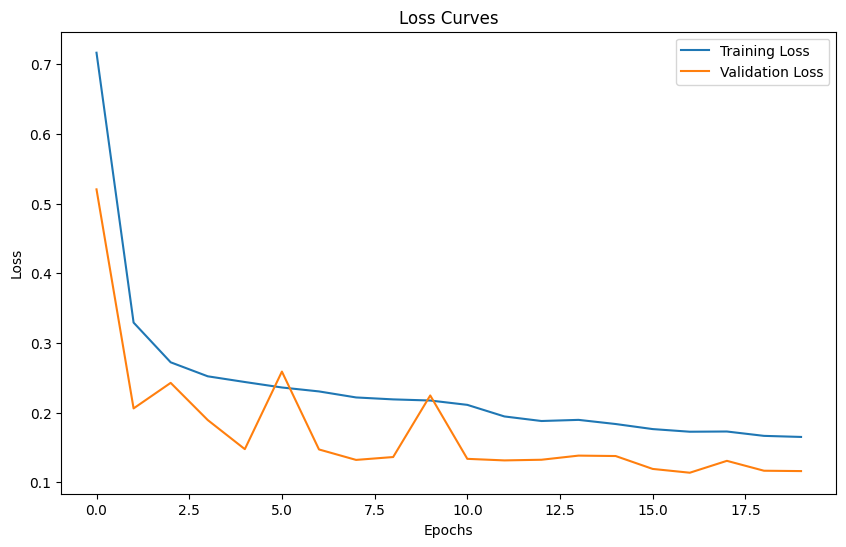

495/495 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9594 - loss: 0.1092
Test Accuracy: 0.9583122730255127


In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on Test Set
test_loss, test_accuracy = CNN_1.evaluate(test_set, steps=len(test_set))
print(f"Test Accuracy: {test_accuracy}")


In [ ]:
import numpy as np

test_image = image.load_img(r'Test_Images/Uninfected.png', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = CNN_1.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'Uninfected'
else:
    prediction = 'Parasitised'
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


'Uninfected'

495/495 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step


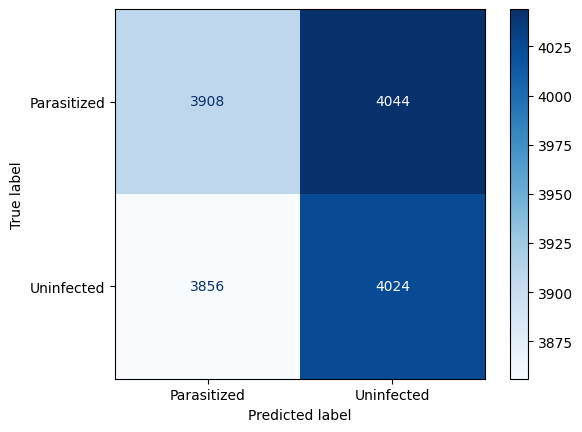

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.50      0.49      0.50      7952
  Uninfected       0.50      0.51      0.50      7880

    accuracy                           0.50     15832
   macro avg       0.50      0.50      0.50     15832
weighted avg       0.50      0.50      0.50     15832



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Confusion Matrix and Classification Report
test_set.reset()
predictions = (CNN_1.predict(test_set) > 0.5).astype('int32')
y_true = test_set.classes

cm = confusion_matrix(y_true, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Parasitized', 'Uninfected'])
cmd.plot(cmap='Blues')
plt.show()


print("Classification Report:")
print(classification_report(y_true, predictions, target_names=['Parasitized', 'Uninfected']))

In [ ]:


# Traditional ML Classifier (SVM) for Comparison
# Extract features using the CNN
feature_extractor = Sequential(CNN_1.layers[:-1])  # Remove final classification layer
features = feature_extractor.predict(training_set)
labels = training_set.classes

# Split into train/test for SVM
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train SVM
svm = SVC(kernel='poly', probability=True)
svm.fit(X_train, y_train)

# Evaluate SVM
y_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {svm_accuracy}")




862/862 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step
SVM Accuracy: 0.49074746008708275


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


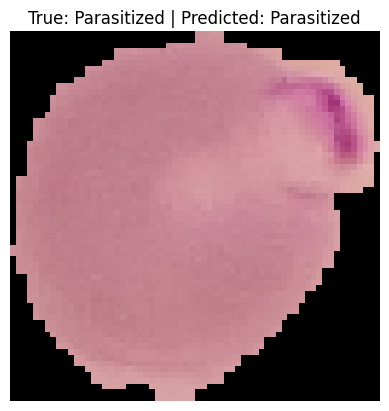

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


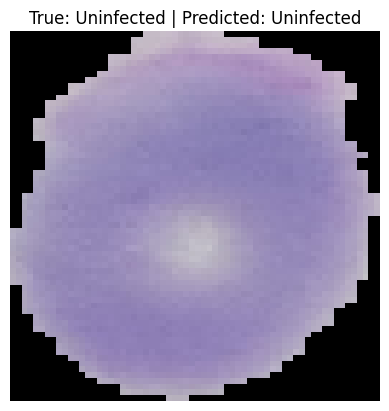

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


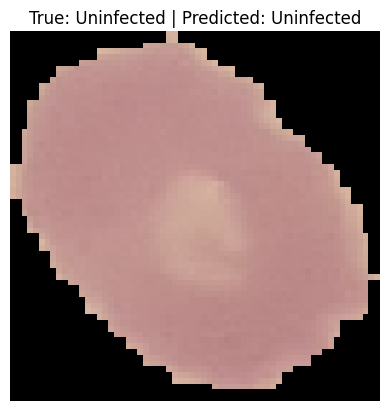

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


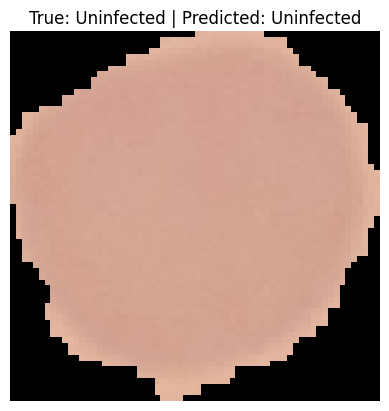

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


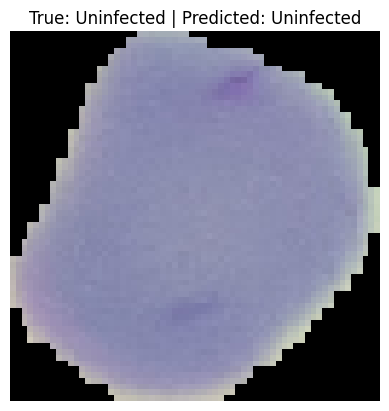

In [ ]:
def visualize_predictions(generator, model, num_samples=5):
    generator.reset()  # Reset the generator to start from the first batch
    for i in range(num_samples):
        image, label = next(generator)  # Use next() to retrieve a batch
        prediction = (model.predict(image) > 0.5).astype('int32')
        
        plt.imshow(image[0])  # Display the first image in the batch
        true_label = 'Parasitized' if label[0] == 0 else 'Uninfected'
        predicted_label = 'Parasitized' if prediction[0][0] == 0 else 'Uninfected'
        
        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()


visualize_predictions(test_set, CNN_1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the DR5-Net model
def build_drsnet():
    model = models.Sequential()

    # Conv1 layer
    model.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=(64, 64, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # MaxPool1 layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Conv2 layer
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # MaxPool2 layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Conv3 layer
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # MaxPool3 layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))

    # Output layer
    model.add(layers.Dense(2, activation='softmax'))  # Two-class classification

    return model

# Build the model
CNN_2 = build_drsnet()

# Compile the model
CNN_2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
CNN_2.summary()


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114,146 (4.25 MB)

 Trainable params: 1,113,922 (4.25 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import LambdaCallback

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


def debug_batch(batch, logs):
    print(f"Batch Shape: {batch}")

debug_callback = LambdaCallback(on_batch_end=debug_batch)

# Add to the fit call
history = CNN_2.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=20,
    validation_data=test_set,
    validation_steps=len(test_set),
    callbacks=[early_stop, reduce_lr, debug_callback],
)



c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
Batch Shape: 0
  1/862 ━━━━━━━━━━━━━━━━━━━━ 1:15:55 5s/step - accuracy: 0.6250 - loss: 0.7176Batch Shape: 1
  2/862 ━━━━━━━━━━━━━━━━━━━━ 1:31 107ms/step - accuracy: 0.5859 - loss: 1.6322Batch Shape: 2
  3/862 ━━━━━━━━━━━━━━━━━━━━ 1:53 132ms/step - accuracy: 0.5712 - loss: 1.7863Batch Shape: 3
  4/862 ━━━━━━━━━━━━━━━━━━━━ 2:01 142ms/step - accuracy: 0.5671 - loss: 1.8208Batch Shape: 4
  5/862 ━━━━━━━━━━━━━━━━━━━━ 2:06 147ms/step - accuracy: 0.5599 - loss: 1.8049Batch Shape: 5
  6/862 ━━━━━━━━━━━━━━━━━━━━ 2:06 148ms/step - accuracy: 0.5543 - loss: 1.7930Batch Shape: 6
  7/862 ━━━━━━━━━━━━━━━━━━━━ 2:13 156ms/step - accuracy: 0.5497 - loss: 1.7763Batch Shape: 7
  8/862 ━━━━━━━━━━━━━━━━━━━━ 2:14 158ms/step - accuracy: 0.5445 - loss: 1.7499Batch Shape: 8
  9/862 ━━━━━━━━━━━━━━━━━━━━ 2:16 160ms/step - accuracy: 0.5384 - loss: 1.7273Batch Shape: 9
 10/862 ━━━━━━━━━━━━━━━━━━━━ 2:20 165ms/step - accuracy: 0.5336 - loss: 1.7016Batch Shape: 10
 11/862 ━━━━━━━━━━━━━━━━━━━━ 2:19 164ms/ste

c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


862/862 ━━━━━━━━━━━━━━━━━━━━ 180s 203ms/step - accuracy: 0.7465 - loss: 0.5438 - val_accuracy: 0.9378 - val_loss: 0.1768 - learning_rate: 0.0010
Epoch 2/20
Batch Shape: 0
  1/862 ━━━━━━━━━━━━━━━━━━━━ 3:23 236ms/step - accuracy: 0.9062 - loss: 0.2048Batch Shape: 1
  2/862 ━━━━━━━━━━━━━━━━━━━━ 1:52 131ms/step - accuracy: 0.9141 - loss: 0.1946Batch Shape: 2
  3/862 ━━━━━━━━━━━━━━━━━━━━ 2:03 144ms/step - accuracy: 0.9219 - loss: 0.1881Batch Shape: 3
  4/862 ━━━━━━━━━━━━━━━━━━━━ 2:07 149ms/step - accuracy: 0.9258 - loss: 0.1893Batch Shape: 4
  5/862 ━━━━━━━━━━━━━━━━━━━━ 2:08 150ms/step - accuracy: 0.9294 - loss: 0.1867Batch Shape: 5
  6/862 ━━━━━━━━━━━━━━━━━━━━ 2:11 154ms/step - accuracy: 0.9325 - loss: 0.1858Batch Shape: 6
  7/862 ━━━━━━━━━━━━━━━━━━━━ 2:10 153ms/step - accuracy: 0.9345 - loss: 0.1868Batch Shape: 7
  8/862 ━━━━━━━━━━━━━━━━━━━━ 2:10 153ms/step - accuracy: 0.9358 - loss: 0.1879Batch Shape: 8
  9/862 ━━━━━━━━━━━━━━━━━━━━ 2:11 154ms/step - accuracy: 0.9368 - loss: 0.1884Batch S

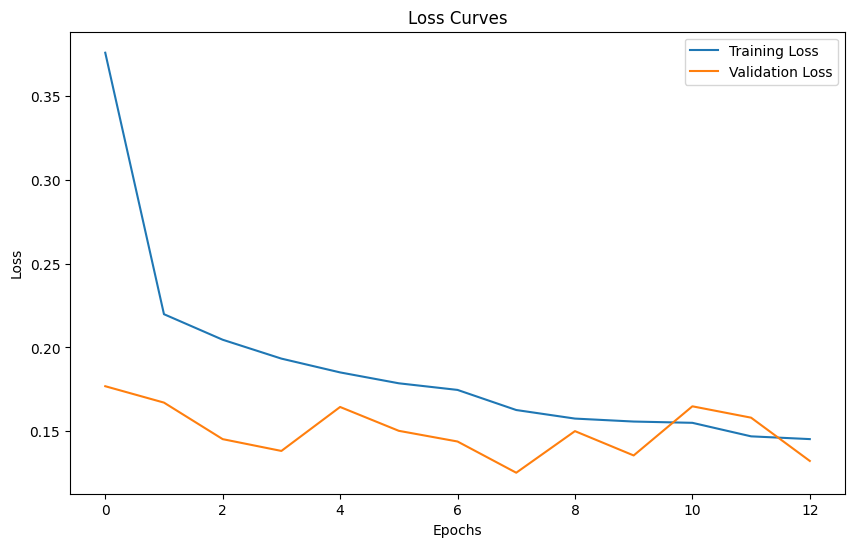

495/495 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9596 - loss: 0.1262
Test Accuracy: 0.9590070843696594


In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on Test Set
test_loss, test_accuracy = CNN_2.evaluate(test_set, steps=len(test_set))
print(f"Test Accuracy: {test_accuracy}")


In [ ]:

# Voting function
def voting_ensemble(models, input_data):
    """
    Perform voting ensemble on the predictions from multiple models.

    Args:
        models (list): List of trained models.
        input_data (numpy array): Input data for prediction.

    Returns:
        numpy array: Final predictions based on majority voting.
    """
    predictions = []

    # Get predictions from each model
    for model in models:
        preds = model.predict(input_data)
        predictions.append(np.argmax(preds, axis=1))

    # Stack predictions and apply majority voting
    stacked_predictions = np.stack(predictions, axis=1)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=stacked_predictions)

    return final_predictions


In [7]:
import numpy as np
from tensorflow.keras.models import load_model

# Load saved models
CNN_1 = load_model("CNN.keras")
# CNN_2 = load_model("model2.h5")
vgg_model = load_model("VGG16.keras")
CNN_2 = load_model("CNN2.keras")
models = [CNN_1, CNN_2, vgg_model]
# # input_data = np.random.rand(10, 64, 64, 3)  # Example: batch of 10 images
# final_predictions = voting_ensemble(models, test_set)
# print(final_predictions)


In [12]:
# Visualization function
def visualize_predictions(generator, models, num_samples=5):
    """
    Visualize images and predictions from a voting ensemble.

    Args:
        generator (ImageDataGenerator): Data generator for images and labels.
        models (list): List of trained models for the ensemble.
        num_samples (int): Number of samples to visualize.
    """
    generator.reset()  # Reset the generator to start from the first batch
    for i in range(num_samples):
        image, label = next(generator)  # Use next() to retrieve a batch
        # Get predictions from the voting ensemble
        prediction = voting_ensemble(models, image)

        # Visualize the first image in the batch
        plt.imshow(image[0])  # Display the first image in the batch
        true_label = 'Class 0' if label[0] == 0 else 'Class 1'
        predicted_label = 'Class 0' if prediction[0] == 0 else 'Class 1'

        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

## Pre-trained model

In [ ]:
# Pretrained Models (Transfer Learning)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load Pretrained Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Layers on Top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the Model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the Model
transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = transfer_model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=10,
    validation_data=test_set,
    validation_steps=len(test_set),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 753s 872ms/step - accuracy: 0.7821 - loss: 0.4586 - val_accuracy: 0.9018 - val_loss: 0.2496 - learning_rate: 0.0010
Epoch 2/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 894s 1s/step - accuracy: 0.8569 - loss: 0.3423 - val_accuracy: 0.9097 - val_loss: 0.2365 - learning_rate: 0.0010
Epoch 3/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 754s 875ms/step - accuracy: 0.8696 - loss: 0.3280 - val_accuracy: 0.9142 - val_loss: 0.2268 - learning_rate: 0.0010
Epoch 4/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 714s 829ms/step - accuracy: 0.8757 - loss: 0.3138 - val_accuracy: 0.9139 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 5/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 806s 935ms/step - accuracy: 0.8718 - loss: 0.3169 - val_accuracy: 0.9130 - val_loss: 0.2417 - learning_rate: 0.0010
Epoch 6/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 844s 979ms/step - accuracy: 0.8760 - loss: 0.3091 - val_accuracy: 0.9174 - val_loss: 0.2221 - learning_rate: 0.0010
Epoch 7/10
862/862 ━━━━━━━━━━━━━━━━━━━━ 711s 825ms/step - accuracy:

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda  # Import Lambda
from tensorflow.keras.applications import Xception

MODEL_PLOT_FILE = "model_plot.png"
TRAINING_LOGS_FILE = "training_logs.csv"

# Input shape (64x64x3)
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# ---------------------------------------------------------------
# Branch 1: Xception (requires ≥71x71)
# ---------------------------------------------------------------
# Upsample input to 71x71 for Xception
xception_resized = Lambda(
    lambda x: tf.image.resize(x, (71, 71)),  # Resize using TensorFlow
    name="xception_upsampling"
)(inputs)

# Initialize Xception with resized input
xception = Xception(
    include_top=False, 
    input_shape=(71, 71, 3), 
    weights='imagenet'
)(xception_resized)

# ---------------------------------------------------------------
# Branch 2: NASNetMobile (works with 64x64)
# ---------------------------------------------------------------
nas_net = NASNetMobile(
    include_top=False, 
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), 
    weights='imagenet'
)(inputs)

# ---------------------------------------------------------------
# Combine branches
# ---------------------------------------------------------------
outputs = Concatenate(axis=-1)([
    GlobalAveragePooling2D()(xception),
    GlobalAveragePooling2D()(nas_net)
])
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

# Build and compile
combination_model = Model(inputs, outputs)
combination_model.compile(
    optimizer=Adam(learning_rate=0.0001, decay=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
combination_model.summary()

# Plot the model
plot_model(
    combination_model,
    to_file=MODEL_PLOT_FILE,
    show_shapes=True,
    show_layer_names=True
)

c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception_upsampling │ (None, 71, 71, 3) │          0 │ input_layer_4[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 3, 3,      │ 20,861,480 │ xception_upsampl… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nasnet_mobile       │ (None, 2, 2,      │  4,269,716 │ input_layer_4[0]… │
│ (Functional)        │ 1056)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1056)      │          0 │ nasnet_mobile[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 3104)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3104)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      3,105 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,134,301 (95.88 MB)

 Trainable params: 25,043,035 (95.53 MB)

 Non-trainable params: 91,266 (356.51 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


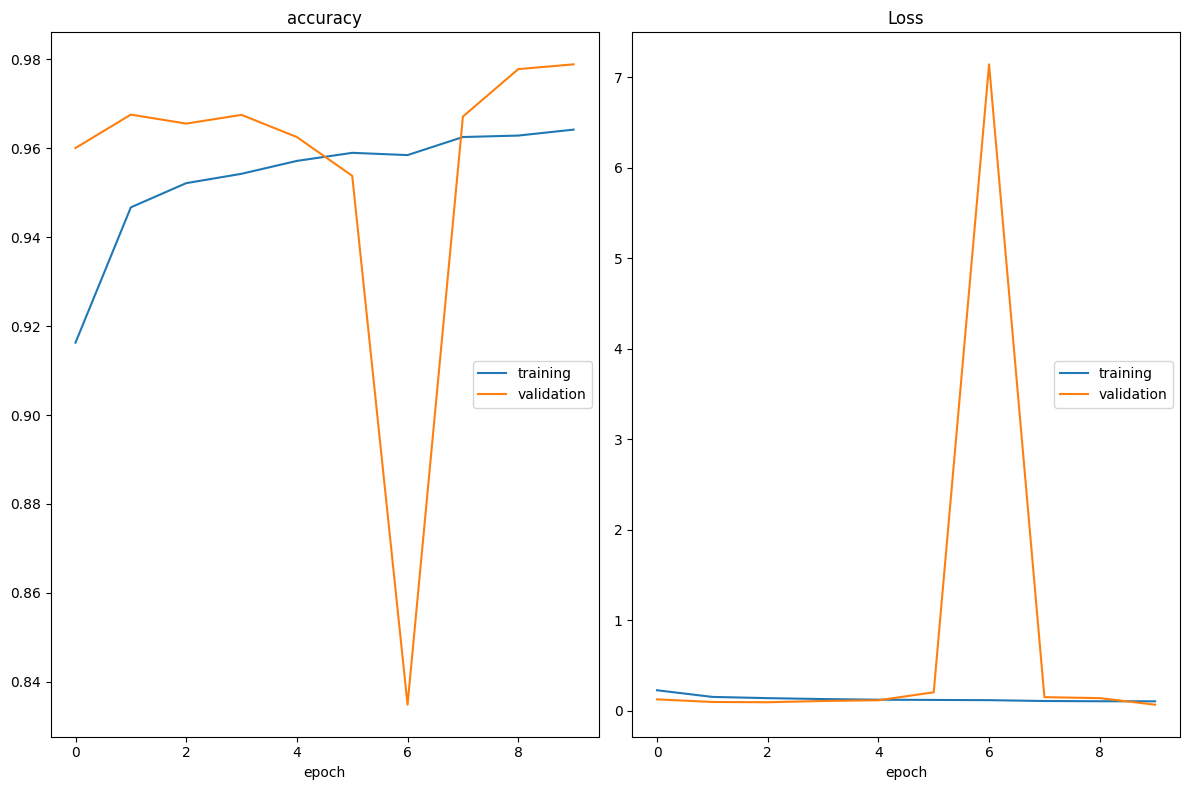

accuracy
	training         	 (min:    0.916, max:    0.964, cur:    0.964)
	validation       	 (min:    0.835, max:    0.979, cur:    0.979)
Loss
	training         	 (min:    0.102, max:    0.224, cur:    0.102)
	validation       	 (min:    0.064, max:    7.144, cur:    0.064)

Epoch 10: val_accuracy improved from 0.97783 to 0.97890, saving model to model.keras
862/862 ━━━━━━━━━━━━━━━━━━━━ 2685s 3s/step - accuracy: 0.9648 - loss: 0.0999 - val_accuracy: 0.9789 - val_loss: 0.0642


In [29]:
#  Training
history = combination_model.fit(
                              training_set,
                              steps_per_epoch=len(training_set), 
                              validation_data=test_set,
                              validation_steps=len(test_set),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                              callbacks=[PlotLossesKeras(),
                                         ModelCheckpoint(filepath="model.keras",
                                                         monitor='val_accuracy',
                                                         verbose=VERBOSITY,
                                                         save_best_only=True,
                                                         mode='max'
                                                        ),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False,
                                                   separator=';')])

In [ ]:
combination_model.save("combination_model.keras")
CNN_2.save("CNN2.keras")

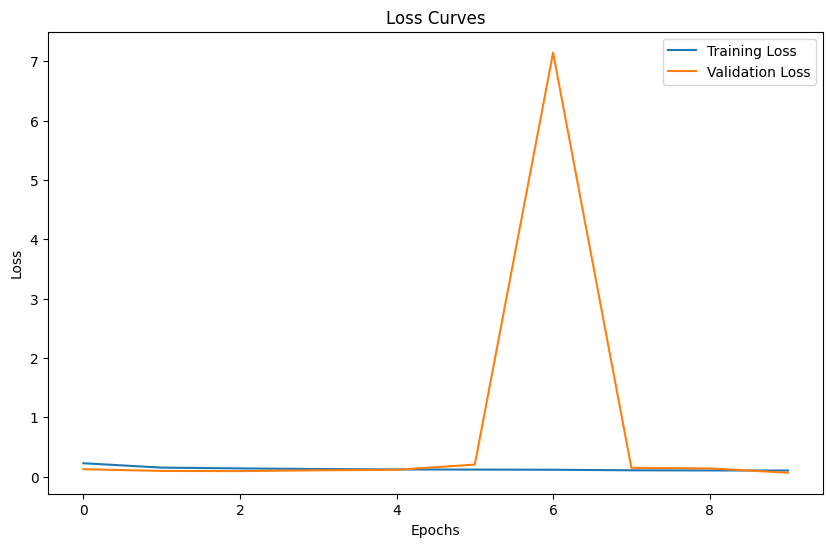

495/495 ━━━━━━━━━━━━━━━━━━━━ 210s 424ms/step - accuracy: 0.9773 - loss: 0.0666
Test Accuracy: 0.9789034724235535


In [31]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on Test Set
test_loss, test_accuracy = combination_model.evaluate(test_set, steps=len(test_set))
print(f"Test Accuracy: {test_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


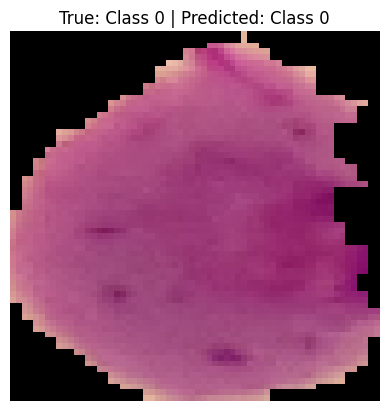

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


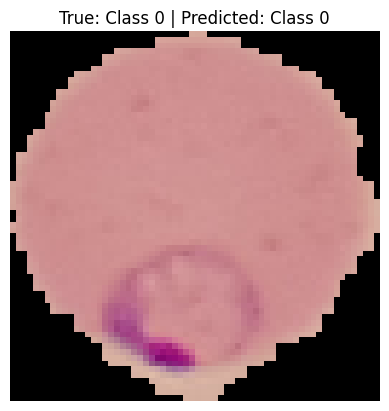

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


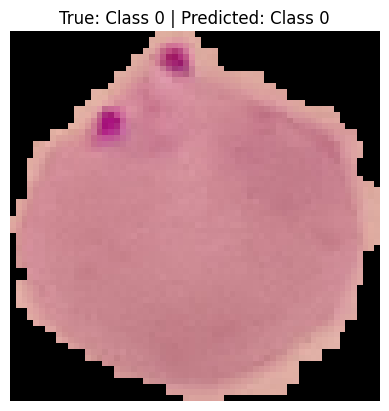

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


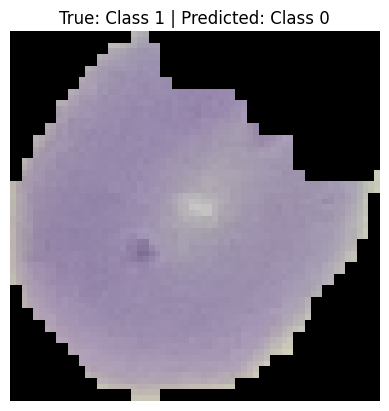

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


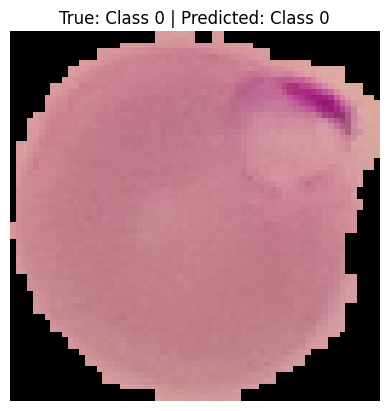

In [ ]:
visualize_predictions(test_set, [CNN_1, CNN_2, combination_model])